In [11]:
#导入相应的包
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [12]:
#定义损失函数
def svm_costFunction(w,X,y,reg):
    margin=1-y*(np.dot(X, np.transpose(w)))
    #max(0,1-y*X*wt),如果小于0就取回为0
    margin[margin<=0]=0
    cost=reg*np.sum(margin)+np.sum(w**2)
    return cost/y.shape[0]

In [13]:
#定义梯度
def svm_w_gradient(w,X,y,reg):
    margin=1-y*(np.dot(X, np.transpose(w)))
    #这个处理可以把小于0置0,大于0的留下来求导
    margin[margin<=0]=0
    margin[margin>0]=1;
    temp=-1*y*X;
    temp=temp*margin
    gradient=reg*np.sum(temp,axis=0)+2*w;
    return gradient

In [14]:
#定义准确率
def svm_predict(w,X,y):
    predict=np.dot(X,np.transpose(w));
    predict=np.sign(predict)
    rate=1-(np.sum(np.abs(y-predict))/2)/y.shape[0]
    return rate;

In [15]:
#随机选取小样本
def random_sample(X,y,m):
    X_random=[]
    y_random=[]
    for i in range(m):
        np.random.seed(i);
        index=int(np.random.rand()*X.shape[0])
        X_random.append(X[index])
        y_random.append(y[index])
    return np.array(X_random),np.array(y_random)

In [36]:
def linear_classification_opti(trainfileName,testfileName):
     #读取文件
    X_train,y_train=load_svmlight_file("a9a")
    X_test,y_test=load_svmlight_file("a9at",n_features=123)
    #稀疏矩阵转ndarray
    X_train=X_train.toarray().astype(float)
    X_test=X_test.toarray().astype(float)
    #保证y的shape
    y_train=np.reshape(y_train,(y_train.shape[0],1))
    y_test=np.reshape(y_test,(y_test.shape[0],1))
    #添加一列全1,提供给b
    X_b=np.ones(X_train.shape[0])
    X_train=np.c_[X_b,X_train]
    X_b=np.ones(X_test.shape[0])
    X_test=np.c_[X_b,X_test]
    iteration_time = [] #迭代次数   
    #NAG
    NAG_test_loss_value = [] #测试数据的loss值
    #rmseprop
    RMSEprop_test_loss_value = [] #测试数据的loss值
    #Adadelta
    Adadelta_test_loss_value = [] #测试数据的loss值
    #Adam
    Adam_test_loss_value = [] #测试数据的loss值
    print("begin")
    #######################NAG##########################
    #初始化参数
    reg=1
    w=np.zeros((1,X_train.shape[1]))
    #学习率
    rate=0.0001
    #动量参数
    u=0.8
    #动量
    v=0 
    for i in range(1000):
        #随机批量梯度
        X_train_random,y_train_random=random_sample(X_train,y_train,2000)
        gradient = svm_w_gradient(w - u * v, X_train_random, y_train_random,reg)
        gradient = np.sum(gradient, axis=0) / gradient.shape[0]
        v = u * v + rate * gradient;
        w = w - v
        NAG_test_loss_value.append(svm_costFunction(w,X_test,y_test,reg))
        iteration_time.append(i+1) 
    print("NAG准确率")
    print(svm_predict(w,X_test,y_test))
    ####################RMSEprop##########################
        #初始化参数
    reg=1
    w=np.zeros((1,X_train.shape[1]))
    rate=0.001#如果rate太大，会跳过最小值，再某个数值之间来回波动
    u=0.8#权重参数
    r=0#指数加权移动平均变量
    theta=0.000001#稳定常数
    for i in range(1000):
        X_train_random, y_train_random = random_sample(X_train, y_train, 2000)
        gradient = svm_w_gradient(w, X_train_random, y_train_random,reg)
        gradient = np.sum(gradient, axis=0) / gradient.shape[0]
        r=u*r+(1-u)*(gradient**2);
        w=w-(rate/np.sqrt(theta+r))*gradient;
        RMSEprop_test_loss_value.append(svm_costFunction(w,X_test,y_test,reg)) 
    print("RMSEprop准确率")
    print(svm_predict(w,X_test,y_test))

    #####################Adadelta##########################
    #初始化参数
    reg=1
    w=np.zeros((1,X_train.shape[1]))
    rate=0.0001
    s=0#对gradient指数加权移动平均变量
    u=0.8#权重参数
    delta=0#对s指数加权移动平均变量
    theta=0.000001#稳定常数
    for i in range(1000):
        X_train_random, y_train_random = random_sample(X_train, y_train, 2000)

        gradient = svm_w_gradient(w, X_train_random, y_train_random,reg)
        gradient = np.sum(gradient, axis=0) / gradient.shape[0]
        s=u*s+(1-u)*(gradient**2);
        g=(np.sqrt(delta+theta)/np.sqrt(s+theta))*gradient
        delta=u*delta+(1-u)*(g**2)
        w=w-g 
        Adadelta_test_loss_value.append(svm_costFunction(w,X_test,y_test,reg))
        
    print("Adadelta准确率")
    print(svm_predict(w,X_test,y_test))
    #######################Adam##########################
    #初始化参数
    reg=1
    v=0#动量变量
    w=np.zeros((1,X_train.shape[1]))
    p1=0.9#动量参数
    p2=0.999#指数加权参数
    theta=0.00000001#稳定常数
    s=0#指数加权移动平均变量
    step=0#次数
    rate=0.001
    for i in range(1000):
        step+=1
        X_train_random, y_train_random = random_sample(X_train, y_train, 2000)
        gradient = svm_w_gradient(w, X_train_random, y_train_random,reg)
        gradient = gradient/ y_train_random.shape[0]
        v=p1*v+(1-p1)*gradient;
        s=p2*s+(1-p2)*(gradient**2)
        v_=v/(1-p1**step)
        s_=s/(1-p2**step)
        w=w-rate*v_/(np.sqrt(s_)+theta)
        Adam_test_loss_value.append(svm_costFunction(w,X_test,y_test,reg))
    print("Adam准确率")
    print(svm_predict(w,X_test,y_test))   
    plt.plot(iteration_time, NAG_test_loss_value , label='NAGTraining Loss')
    plt.plot(iteration_time, RMSEprop_test_loss_value,label='RMSEpropTraining Loss')
    plt.plot(iteration_time, Adadelta_test_loss_value,label='AdadeltapropTraining Loss')
    plt.plot(iteration_time, Adam_test_loss_value,label='AdampropTraining Loss')
    plt.title('loss')
    plt.legend()
    plt.show()
    
    
    

begin
NAG准确率
0.844297033352
RMSEprop准确率
0.844112769486
Adadelta准确率
0.844419875929
Adam准确率
0.840550334746


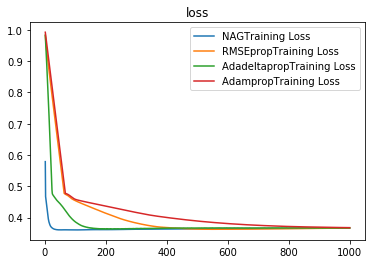

In [37]:
linear_classification_opti("a9a","a9at")

In [ ]:
def NAG_opti(rate,u,v,gradient,w):
    v = u * v + rate * gradient;
    w = w - v
    return w
def Adam_opti(p1,p2,theta,s,step,rate,gradient,w,v):
    v=p1*v+(1-p1)*gradient;
    s=p2*s+(1-p2)*(gradient**2)
    v_=v/(1-p1**step)
    s_=s/(1-p2**step)
    w=w-rate*v_/(np.sqrt(s_)+theta)
    return w
def RMSEprop_opti(r,u,theta,gradient,w,rate):
    r=u*r+(1-u)*(gradient**2);
    w=w-(rate/np.sqrt(theta+r))*gradient;
    return w
def Adadelta_opti(s,u,delta,theta,w,gradient):
    s=u*s+(1-u)*(gradient**2);
    g=(np.sqrt(delta+theta)/np.sqrt(s+theta))*gradient
    delta=u*delta+(1-u)*(g**2)
    w=w-g
    return w